In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import pypairix
import bioframe
import cooltools
from cooltools.expected import compute_scaling
import bioframe.dask

/home/an27w/lib/miniconda3/lib/python3.7/site-packages/bioframe/dask.py:49: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "reg2bins" failed type inference due to: No conversion from list(int64) to int32 for '$278.2', defined at None

File "../../../../../../../../home/an27w/lib/miniconda3/lib/python3.7/site-packages/bioframe/dask.py", line 81:
def reg2bins(rbeg, rend):
    <source elided>
    
    return lst
    ^

[1] During: typing of assignment at /home/an27w/lib/miniconda3/lib/python3.7/site-packages/bioframe/dask.py (81)

File "../../../../../../../../home/an27w/lib/miniconda3/lib/python3.7/site-packages/bioframe/dask.py", line 81:
def reg2bins(rbeg, rend):
    <source elided>
    
    return lst
    ^

  @numba.jit("int32(int32, int32)")
/home/an27w/lib/miniconda3/lib/python3.7/site-packages/bioframe/dask.py:49: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "reg2bins" fa

In [41]:
import six
from bioframe.core import argnatsort, parse_region
def read_chromsizes(filepath_or,
                    name_patterns=(r'^chr[0-9]+$', r'^chr[XY]$', r'^chrM$', r'^HAWscaffold[0-9]+$'),
                    natsort=True,
                    **kwargs):
    """
    Parse a ``<db>.chrom.sizes`` or ``<db>.chromInfo.txt`` file from the UCSC
    database, where ``db`` is a genome assembly name.
    Parameters
    ----------
    filepath_or : str or file-like
        Path or url to text file, or buffer.
    name_patterns : sequence, optional
        Sequence of regular expressions to capture desired sequence names.
        Each corresponding set of records will be sorted in natural order.
    all_names : bool, optional
        Whether to return all contigs listed in the file. Default is
        ``False``.
    Returns
    -------
    Series of integer bp lengths indexed by sequence name.
    See also
    --------
    * UCSC assembly terminology: <http://genome.ucsc.edu/FAQ/FAQdownloads.html#download9>
    * NCBI assembly terminology: <https://www.ncbi.nlm.nih.gov/grc/help/definitions>
    """
    if kwargs.pop('all_names', False):
        name_patterns = 'all'
    if isinstance(filepath_or, six.string_types) and filepath_or.endswith('.gz'):
        kwargs.setdefault('compression', 'gzip')

    chromtable = pd.read_csv(
        filepath_or, sep='\t', usecols=[0, 1],
        names=['name', 'length'], dtype={'name':str}, **kwargs)

    if name_patterns != 'all':
        parts = []
        for pattern in name_patterns:
            if not len(pattern): continue
            part = chromtable[chromtable['name'].str.contains(pattern)]
            if natsort:
                part = part.iloc[argnatsort(part['name'])]
            parts.append(part)
        chromtable = pd.concat(parts, axis=0)

    chromtable.index = chromtable['name'].values
    return chromtable['length']

In [48]:
#chromsizes=read_chromsizes('/nl/umw_job_dekker/users/an27w/sing-distiller/apitasia/HAW_R3_locked.scaffolds.rn.chrom.sizes')
chromsizes=read_chromsizes('/nl/umw_job_dekker/users/an27w/sing-distiller/apitasia/HAWv1_R3locked.scaffolds.hdrrn.ptmasked.chrom.sizes')

chromsizes


HAWscaffold1       499811
HAWscaffold2        65655
HAWscaffold3      2669558
HAWscaffold4      1916504
HAWscaffold5      3114035
                   ...   
HAWscaffold138      43235
HAWscaffold139      42126
HAWscaffold140      40018
HAWscaffold141      39564
HAWscaffold142      36051
Name: length, Length: 142, dtype: int64

In [53]:
conditions = ['rn', 'hdrn']
binsize = 100000

pairs_paths = {
    'rn': 'M-19-3656_HAW_S731-S571.HAW_R3_locked.scaffolds.rn.nodups.pairs.gz',
    'hdrn': '/nl/umw_job_dekker/users/an27w/sing-distiller/apitasia-2/results/pairs_library/M-19-3656_HAW_S731-S571.HAWv1_R3locked.scaffolds.hdrrn.ptmasked.nodups.pairs.gz',
}
long_names = {
    'rn': 'M-19-3656_HAW_S731-S571.HAW_R3_locked.scaffolds.rn',
    'hdrn': 'M-19-3656_HAW_S731-S571.HAWv1_R3locked.scaffolds.hdrrn.ptmasked',
}

pal = sns.color_palette('colorblind')
colors = {
    'rn': pal[0],
    'hdrn': pal[1],
}


In [54]:
pairs_header = ['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type','mapq1', 'mapq2']
chrom = 'HAWscaffold1'

In [55]:
df = bioframe.dask.read_pairix_block(
    pairs_paths['hdrn'], 
    (chrom, chrom),
    names=pairs_header,
    chromsizes=chromsizes,
    chunk_level=0)

df = df.compute()
print(len(df))
df.head()


20318


,read_id,chrom1,pos1,chrom2,pos2,strand1,strand2,pair_type,mapq1,mapq2
0,.,HAWscaffold1,127,HAWscaffold1,312,+,-,UU,2,43
1,.,HAWscaffold1,134,HAWscaffold1,323,+,-,UU,6,43
2,.,HAWscaffold1,134,HAWscaffold1,379,+,-,UU,5,7
3,.,HAWscaffold1,137,HAWscaffold1,279,+,-,UU,20,20
4,.,HAWscaffold1,142,HAWscaffold1,403,+,-,UU,19,42


/home/an27w/lib/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


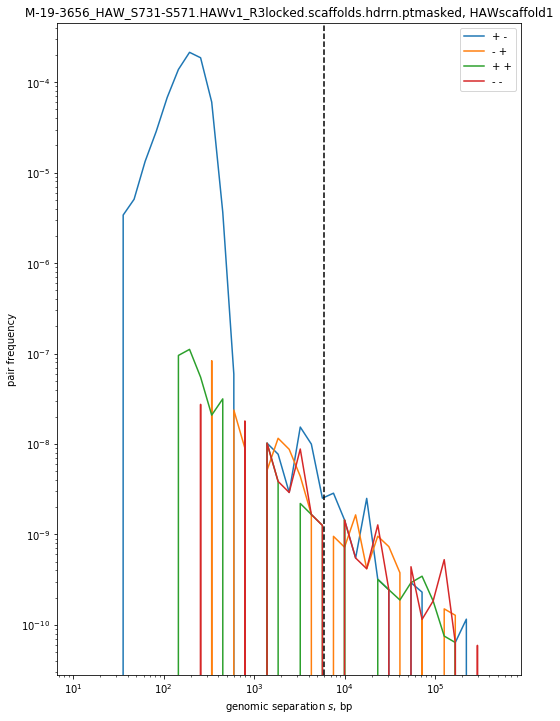

In [56]:
plt.figure(figsize=(12, 12))

dmin = 10
dmax = int(1e7)

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

grouped = df.groupby(['strand1', 'strand2'])

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    
    dbins, obs, areas = compute_scaling(
        group, 
        region1=[0, chromsizes[chrom]], 
        region2=[0, chromsizes[chrom]],
        dmin=dmin, 
        dmax=dmax)
    
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.axvline(6000, c='k', ls='--')
plt.gca().set_aspect(1)
plt.title(f'M-19-3656_HAW_S731-S571.HAWv1_R3locked.scaffolds.hdrrn.ptmasked, {chrom}')
plt.savefig('readOrn-M-19-3656_HAW_S731-S571.HAWv1_R3locked.scaffolds.hdrrn.ptmasked.scalingPlot.svg', format='svg', dpi = 300)



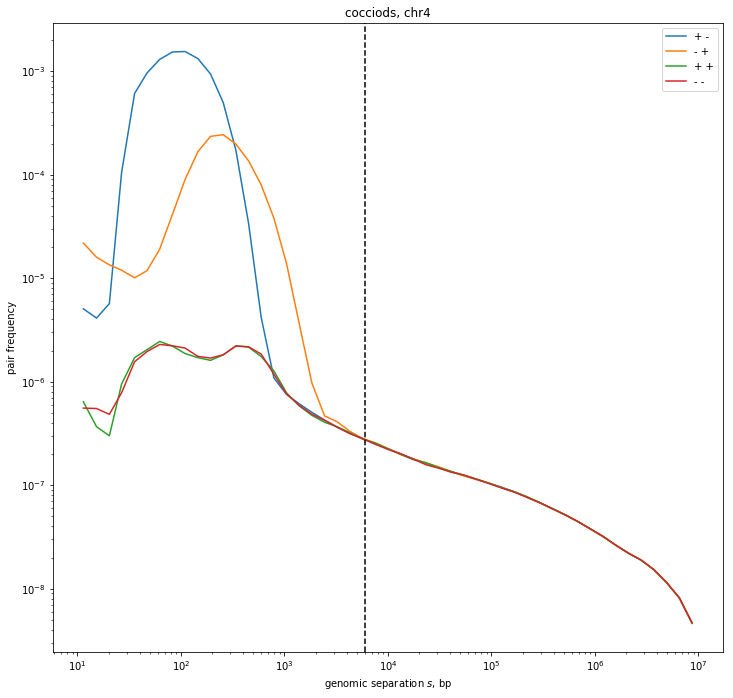

In [8]:
df = bioframe.dask.read_pairix_block(
    pairs_paths['cD'], 
    (chrom, chrom),
    names=pairs_header,
    chromsizes=chromsizes,
    chunk_level=0)

df = df.compute()
plt.figure(figsize=(12, 12))

dmin = 10
dmax = int(1e7)

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

grouped = df.groupby(['strand1', 'strand2'])

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    
    dbins, obs, areas = compute_scaling(
        group, 
        region1=[0, chromsizes[chrom]], 
        region2=[0, chromsizes[chrom]],
        dmin=dmin, 
        dmax=dmax)
    
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.axvline(6000, c='k', ls='--')
plt.gca().set_aspect(1)
plt.title(f'cocciods, {chrom}')
plt.savefig('readOrn-cDplus.scalingPlot.svg', format='svg', dpi = 300)

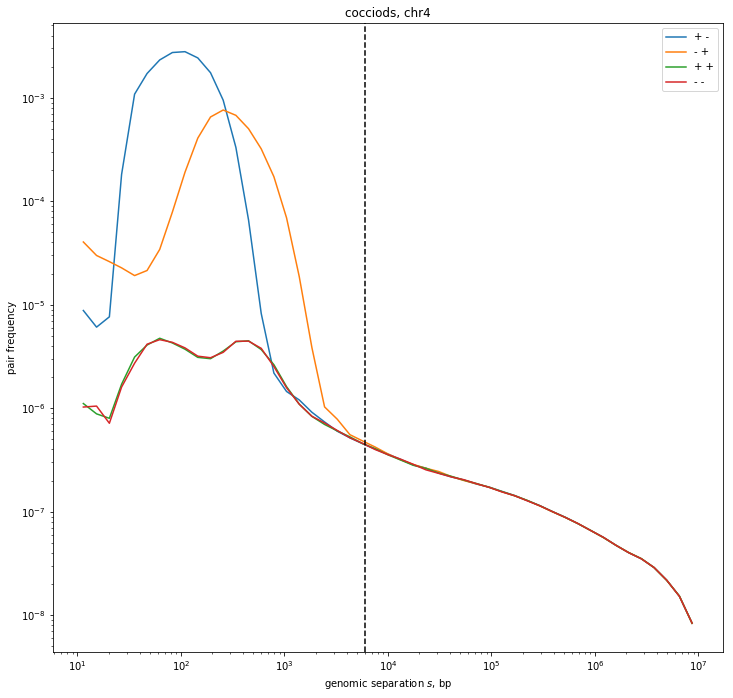

In [9]:
df = bioframe.dask.read_pairix_block(
    pairs_paths['D'], 
    (chrom, chrom),
    names=pairs_header,
    chromsizes=chromsizes,
    chunk_level=0)

df = df.compute()


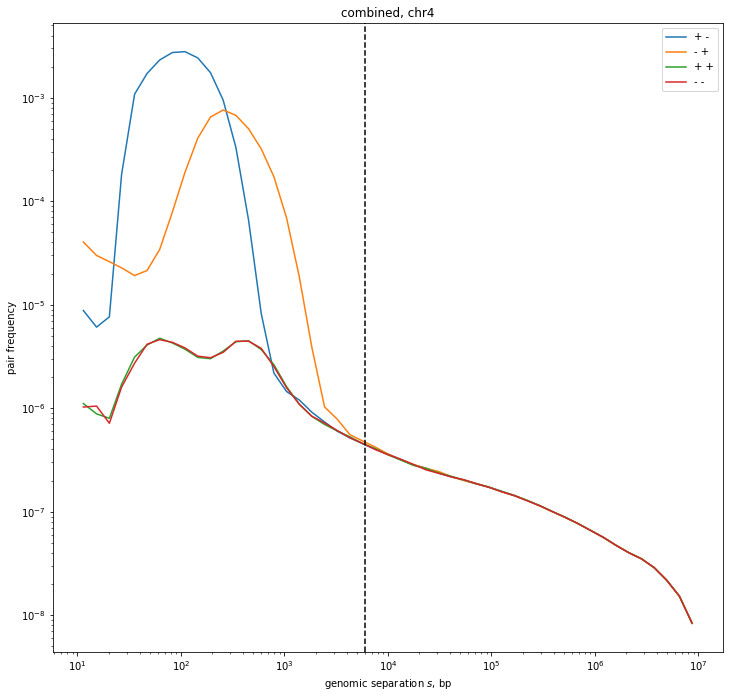

In [10]:
plt.figure(figsize=(12, 12))

dmin = 10
dmax = int(1e7)

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

grouped = df.groupby(['strand1', 'strand2'])

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    
    dbins, obs, areas = compute_scaling(
        group, 
        region1=[0, chromsizes[chrom]], 
        region2=[0, chromsizes[chrom]],
        dmin=dmin, 
        dmax=dmax)
    
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.axvline(6000, c='k', ls='--')
plt.gca().set_aspect(1)
plt.title(f'combined, {chrom}')
plt.savefig('readOrn-Dplus.scalingPlot.svg', format='svg', dpi = 300)

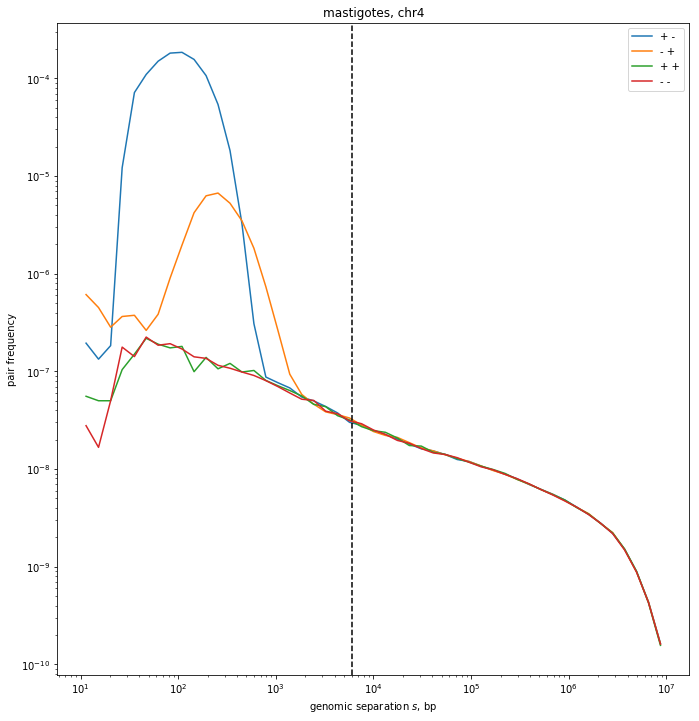

In [16]:
df = bioframe.dask.read_pairix_block(
    pairs_paths['cDSG'], 
    (chrom, chrom),
    names=pairs_header,
    chromsizes=chromsizes,
    chunk_level=0)

df = df.compute()
plt.figure(figsize=(12, 12))

dmin = 10
dmax = int(1e7)

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

grouped = df.groupby(['strand1', 'strand2'])

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    
    dbins, obs, areas = compute_scaling(
        group, 
        region1=[0, chromsizes[chrom]], 
        region2=[0, chromsizes[chrom]],
        dmin=dmin, 
        dmax=dmax)
    
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.axvline(6000, c='k', ls='--')
plt.gca().set_aspect(1)
plt.title(f'mastigotes, {chrom}')
plt.savefig('readOrn-cDplus-DSG.scalingPlot.pdf', format='pdf', dpi = 300)